# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [2]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4

import os
import glob
import xarray as xr

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [3]:
# define the path to the folder where the SSH data has been download on your machine
data_folder = '/home/tara/Data'

ssh_folder = os.path.join(data_folder,'ECCO','Version4','Release4',
                        'interp_monthly','SSHDYN')

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [4]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
ds_jan_1992 = xr.open_dataset(os.path.join(ssh_folder,'SSHDYN_1992_01.nc'))
latitude = ds_jan_1992['latitude'].values
longitude = ds_jan_1992['longitude'].values
ssh_1992 = ds_jan_1992['SSHDYN'].values
ds_jan_1992.close()

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ds_jan_2017 = xr.open_dataset(os.path.join(ssh_folder,'SSHDYN_2017_01.nc'))
ssh_2017 = ds_jan_2017['SSHDYN'].values
ds_jan_2017.close()

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

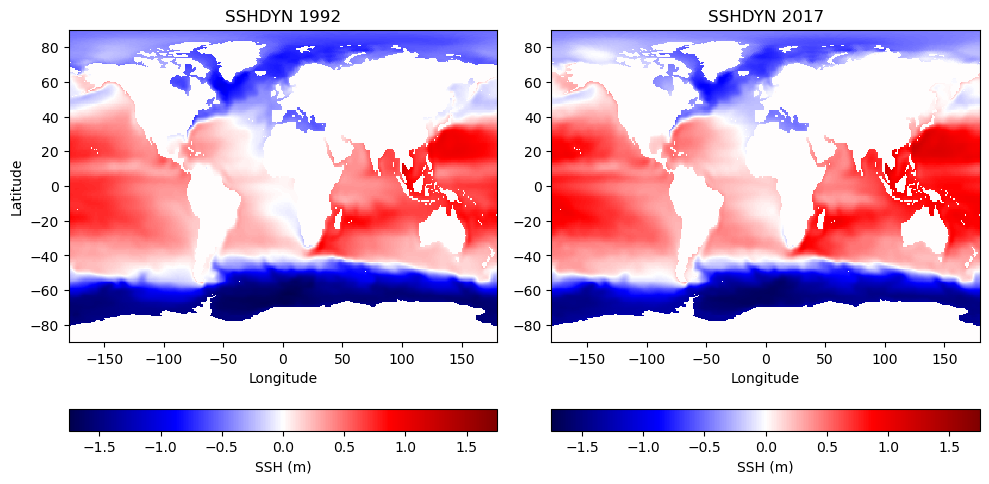

In [5]:
# make a plot of the differences between 2017 and 1992
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(longitude,latitude,ssh_1992[0], cmap='seismic', vmin = -1.75, vmax= 1.75)
plt.colorbar(C, orientation='horizontal',
             label='SSH (m)' )
plt.title('SSHDYN 1992')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.subplot(1,2,2)
C = plt.pcolormesh(longitude,latitude,ssh_2017[0], cmap='seismic', vmin = -1.75, vmax= 1.75)
plt.colorbar(C, orientation='horizontal',
             label='SSH (m)' )
plt.title('SSHDYN 2017')
# plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.tight_layout()
plt.show()



In [ ]:
SSH_diff = ssh_2017 - ssh_1992

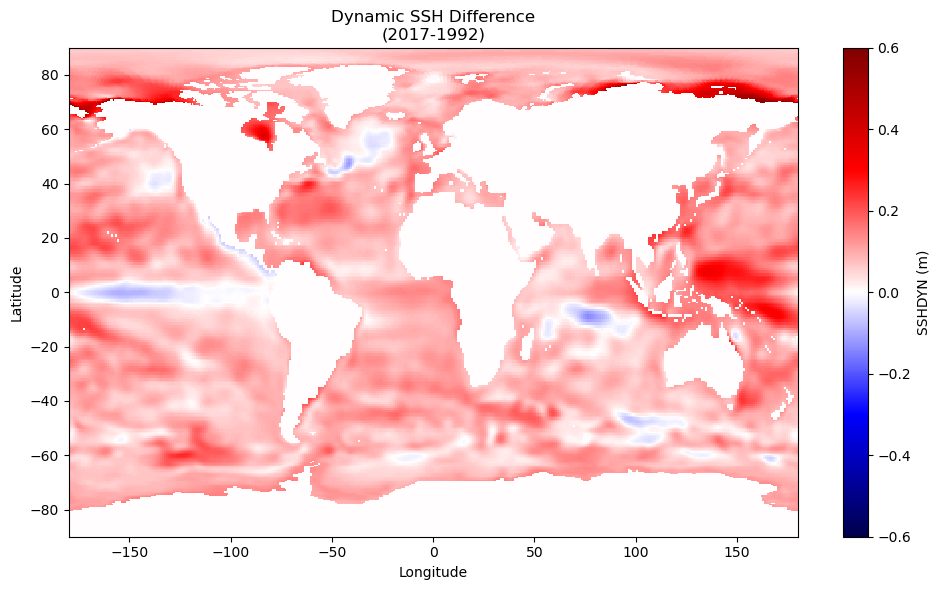

In [44]:
# make a plot of the differences between 2017 and 1992
fig = plt.figure(figsize=(10,6))

C = plt.pcolormesh(longitude,latitude,SSH_diff[0], cmap='seismic', vmin = -.6, vmax= .6)
plt.colorbar(C, orientation='vertical',
             label='SSHDYN (m)' )
plt.title('Dynamic SSH Difference\n(2017-1992)')
plt.ylabel('Latitude')
plt.xlabel('Longitude')


plt.tight_layout()
plt.show()



### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: 

The largest increse in sea level observed between these two time periods is 0.5769 m.

The sea level has fallen in a few areas: 

- The equator, west of South America. 
- Near the equator, east of Africa. 
- South of Greenland. 
- West of California. 
- Along the west coast of Mexico. 
- South of Austrailia. 

In [32]:
print(f'The largest increse in sea level observed between these two time periods is {np.max(SSH_diff):.4f} m')

The largest increse in sea level observed between these two time periods is 0.5769 m


## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [8]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lat_idx = np.argmin(np.abs(latitude - lat))
lon_idx = np.argmin(np.abs(longitude - lon))

Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [9]:
ssh_files = glob.glob(os.path.join(ssh_folder,'SSHDYN_*.nc'))
ssh_files.sort()
print(f'{len(ssh_files)} files')

312 files


In [14]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
cal_ssh = np.zeros((len(ssh_files),2))

for i, file in enumerate(ssh_files):
    print(f'{i+1} of {len(ssh_files)}', end='\r')
    ds = xr.open_dataset(file)
    cal_ssh[i,0] = ds['time'].values[0]
    cal_ssh[i,1] = ds['SSHDYN'].values[0,lat_idx,lon_idx]
    ds.close()


print(f'\nTimeseries shape: {cal_ssh.shape}')

312 of 312
Timeseries shape: (312, 2)


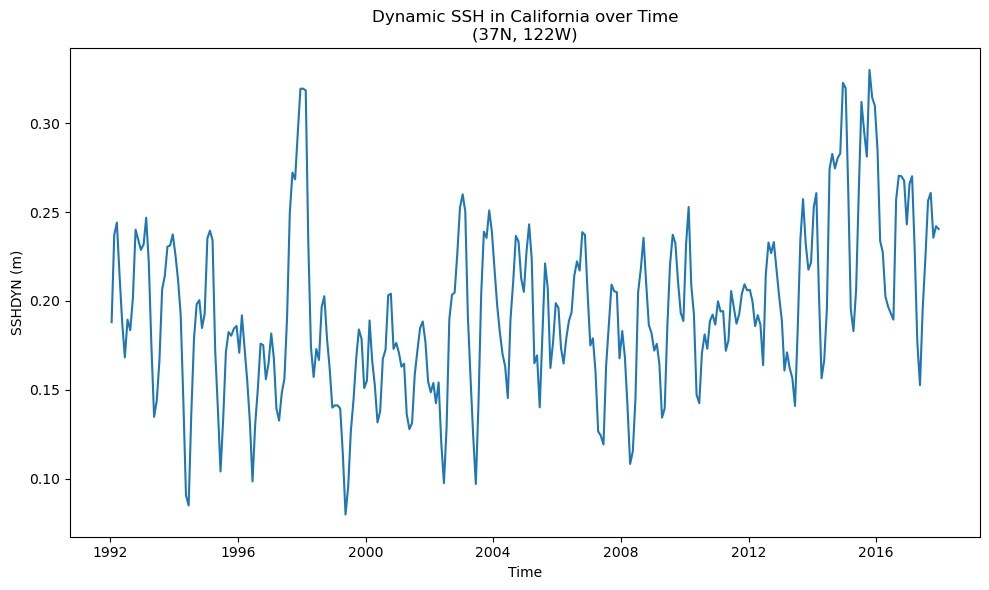

In [16]:
fig = plt.figure(figsize=(10,6))

plt.plot(cal_ssh[:, 0].astype('datetime64[ns]'),cal_ssh[:,1])
plt.title('Dynamic SSH in California over Time\n(37N, 122W)')
plt.ylabel('SSHDYN (m)')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

In [17]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
global_ssh = np.zeros((len(ssh_files),2))

for i, file in enumerate(ssh_files):
    print(f'{i+1} of {len(ssh_files)}', end='\r')
    ds = xr.open_dataset(file)
    ds = ds.where(ds['SSHDYN'] != 0, drop=True)

    global_ssh[i,0] = ds['time'].values[0]
    global_ssh[i,1] = ds['SSHDYN'].mean(skipna=True).values
    
    ds.close()

print(f'\nTimeseries shape: {global_ssh.shape}')

312 of 312
Timeseries shape: (312, 2)


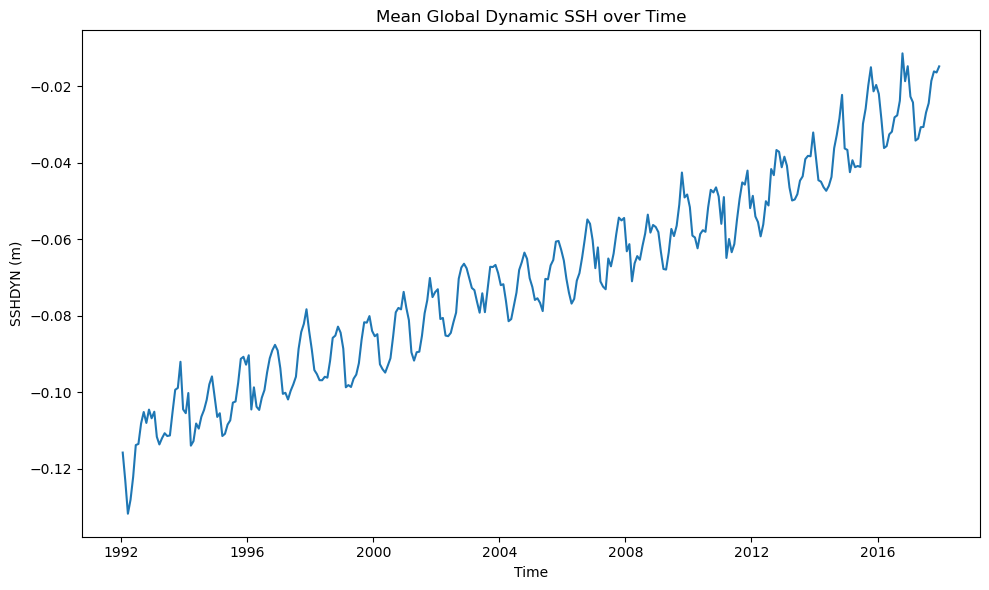

In [19]:
fig = plt.figure(figsize=(10,6))

plt.plot(global_ssh[:, 0].astype('datetime64[ns]'),global_ssh[:,1])
plt.title('Mean Global Dynamic SSH over Time')
plt.ylabel('SSHDYN (m)')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [20]:
# define a time array for months
months = np.arange(len(global_ssh))

# convert to "decimal years"
dec_yrs = 1992 + months/12

In [22]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
# compute the line coefficients
m_cal, b_cal = np.polyfit(dec_yrs, cal_ssh[:,1], 1)
m_glb, b_glb = np.polyfit(dec_yrs, global_ssh[:,1], 1)

# print the coefficients
print(f'Cal- slope: {m_cal:0.4f}, intercept: {b_cal:0.4f}') # slope is in m/month
print(f'Gbl- slope: {m_glb:0.4f}, intercept: {b_glb:0.4f}\n')

# print out the statistics in mm/yr for each timeseries
print(f'{"California:":11} {m_cal*1000*12:.4f} mm/yr')
print(f'{"Global:":11} {m_glb*1000*12:.4f} mm/yr')

Cal- slope: 0.0021, intercept: -3.9719
Gbl- slope: 0.0034, intercept: -6.8405

California: 24.9373 mm/yr
Global:     40.5218 mm/yr


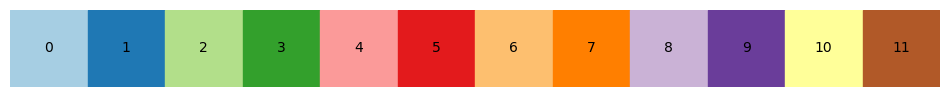

In [129]:
num_colors = plt.cm.Paired.N

fig, ax = plt.subplots(figsize=(12, 1))

for i in range(num_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=plt.cm.Paired(i / num_colors)))
    ax.text(i + 0.5, 0.5, str(i), va='center', ha='center')

ax.set_xlim(0, num_colors)
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The California trend looks similar visually in the plot; However, if we look at the slope coefficients, we can see that California sea height is increasing at half the rate of the global average (in mm/yr). 

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

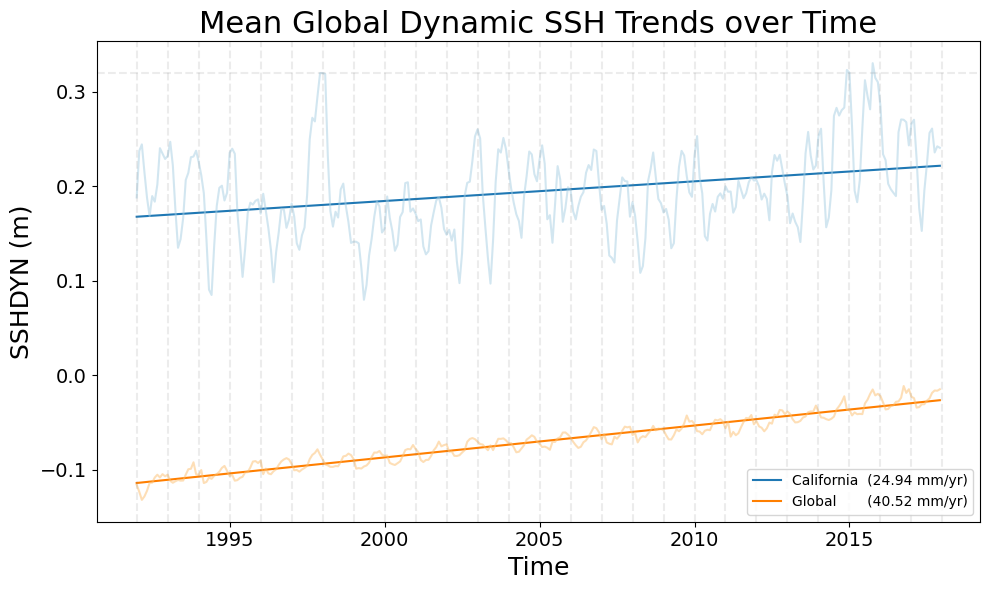

In [23]:
fig = plt.figure(figsize=(10,6))

plt.plot(dec_yrs, m_cal*dec_yrs + b_cal, label=f'{"California":11} ({m_cal*1000*12:.2f} mm/yr)', color = plt.cm.Paired(1/12))
plt.plot(dec_yrs, cal_ssh[:,1], color = plt.cm.Paired(0/12), alpha = 0.5)

plt.plot(dec_yrs, m_glb*dec_yrs + b_glb, label=f'{"Global":12} ({m_glb*1000*12:.2f} mm/yr)', color = plt.cm.Paired(7/12))
plt.plot(dec_yrs, global_ssh[:,1], alpha = 0.5, color = plt.cm.Paired(6/12))

for year in range(1992, 2019):
    plt.axvline(year, color='gray', linestyle='--', alpha=0.15)

plt.axhline(0.32, color='gray', linestyle='--', alpha=0.15)

plt.title('Mean Global Dynamic SSH Trends over Time', fontsize = 22)

plt.ylabel('SSHDYN (m)', fontsize = 18)
plt.xlabel('Time', fontsize = 18)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.legend()

plt.tight_layout()
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: 

The SSH for California is larger (higher?) than the Global average, however California SSH is not increasing as fast over time as the global average is. California SSH is increasing at ~25 mm/yr whereas the global mean SSH is increasing at ~40 mm/yr. 

California has much larger variability in the data than the global average. I would guess this is because the global SSH takes into account all of the seas. 

The highest years for California are 2014/2015. Specifically, the end of 2014 into early 2015 and also at the end of 2015 into 2016. There is another peak around 1997/1998. I believe these were El Niño years. 